# Neural network training for Napari-LF

Napari-LF neural net integration relies on Pytorch-lightning (PL) workflow. Which provides general functions for loading data, training, inference, etc. That can be used with any neural network.
This script is intended for preparing a network to use with Napari-LF.

PL provides function hooks for the main tasks required during training/testing a network, functions like:
(See LFNeuralNetworksProto.py or VCDNet.py for examples)
- configure_optimizers: Create an optimizer and save it to the network object. In our case we use ADAM
- training_step / validation_step: These functions are called by the trainer created in step 5. Note that LFMNet and VCDNet use the same training/validation functions, that's why we overload this functions in the base class.


## Instructions
1. Import required libraries and desired network to train.
2. Gather needed information from user
3. Create a network.
4. Load data for training.
5. Train network.
6. Use the network to reconstruct a sample

**Extra**: Load and continue training a network from a checkpoint. Then evaluate on an image.

### 1. Import required libraries and desired network to train.

In [7]:
import pytorch_lightning as pl
import torch
# Let's train a VCDNet. This defines which network we will train
from neural_nets.VCDNet import VCDNet as NN
# Or:
# from neural_nets.LFMNet import LFMNet as NN

### 2. Gather needed information from user

In [8]:
n_gpus = 1 # Minimum is 1, if your computer doesn't have a dedicated GPU, ignore this option
# What is the shape of our Light-field [angular-u, angular-v, spatial-s, spatial-t]
LFshape = [33,33,39,39]     # For the case of the MouseBrain dataset
LF_2D_shape = [LFshape[0]*LFshape[2], LFshape[1]*LFshape[3]]
# How many depths are present in each volume?
n_depths = 64

# Define training parameters
training_settings = {}
# Learning rate
training_settings['lr'] = 1e-3    
# Batch size              
training_settings['batch_size'] = 1
# max epochs to train        
training_settings['epochs'] = 2
# Which image-volume pairs to use
training_settings['images_ids'] = list(range(5))                                               
# Where is the data
training_settings['dataset_path'] = '/Users/page/Documents/PhD/Datasets/Brain_40x_64Depths_362imgs.h5'    
# Where to store the trained network?
training_settings['output_dir'] = '/Users/page/Documents/PhD/MBL_visit/Projects/napari-LF/runs/'
# Where to store the trained network?
training_settings['output_prefix'] = ''    # if left blank incremental versioning will be used 'version_*'

### 3. Create a network
Neural networks are derived classes based on a common LFNeuralNetworkProto.py and share the same constructor.
Hence we can use it with any network (LFMNet, VCDNet, ...) as long as we import it as NN (see import on the top) and its derived from the LFNeuralNetworkProto class.

In [9]:
input_shape = LF_2D_shape
output_shape = (n_depths,)+tuple(LF_2D_shape)
# Create our network
net = NN(input_shape, output_shape, 
         network_settings_dict={'LFshape' : LFshape}, 
         training_settings_dict=training_settings)

### 4. Load data for training.
The PL trainer object (in the next step), requires a train and validation dataloader.
In the configure_dataloader() function, we define the members:
- net.train_loader, net.val_loader are of type torch.utils.data.DataLoader and wrap a Dataset object implementing functions like: \_\_getitem\_\_ and \_\_len\_\_ (see Dataset in LFUtil.py)
- max_LF_train, max_vol_train: Normalization values stored during training, which are used to normalize the data every time a reconstruction is required.

Each network should have its custom dataloder. As LFMNet and VCDNet use different shape of LF as inpute, each have their own implementation of configure_dataloder().

In [10]:
net.configure_dataloader()
# img_out = LF2Spatial(net.train_loader.dataset[0][0].unsqueeze(0), LFshape)
# import lfdeconvolve
# lfdeconvolve.save_image('./img_out.tif', img_out[0][0].numpy())

Loading images: 100%|██████████| 5/5 [00:08<00:00,  1.65s/it]


### 5. Train network.

#### 5.1 Where to save the logs?

In [15]:
# Do we log to the default directory? or to a specified one 
tb_logger = True
output_path = './lightning_logs/'
if len(training_settings['output_dir']) > 0: # Do we have a path for the logging?
    # Define network type
    network_name = net.__class__.__name__
    from pytorch_lightning import loggers as pl_loggers
    version = None if len(training_settings['output_prefix'])==0 else training_settings['output_prefix']
    tb_logger = pl_loggers.TensorBoardLogger(save_dir=f"{training_settings['output_dir']}/", name=network_name, version=version)
    output_path = f"{training_settings['output_dir']}/{network_name}"

print(f'###################### Logging to: {output_path}' )
print(f'run in the terminal to view progress:')
print(f'tensorboard --logdir={tb_logger.log_dir}')

###################### Logging to: /Users/page/Documents/PhD/MBL_visit/Projects/napari-LF/runs//VCDNet
run in the terminal to view progress:
tensorboard --logdir=/Users/page/Documents/PhD/MBL_visit/Projects/napari-LF/runs//VCDNet/version_2


#### 5.2: Train the network
For training we use PL trainers, specify which computing devices use and on which data (train/val_dataloaders loaded in step 4).

In [12]:
# Create a trainer
device = "cpu"
# Check for Mac M1 & M2 device
if torch.cuda.device_count()>0:
    device = "gpu"
print(f'Using device: {device}')
trainer = pl.Trainer(logger=tb_logger, accelerator=device, devices=max([n_gpus,1]), precision=32, max_epochs=net.get_train_setting('epochs'))
# Train the network 
trainer.fit(model=net, train_dataloaders=net.train_loader, val_dataloaders=net.val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type       | Params
----------------------------------------------
0 | net_upsample   | Sequential | 6.9 M 
1 | encoder_layers | Sequential | 3.9 M 
2 | decoder_layers | Sequential | 9.4 M 
----------------------------------------------
20.2 M    Trainable params
0         Non-trainable params
20.2 M    Total params
80.707    Total estimated model params size (MB)


Using device: cpu
                                                                           

/Users/page/miniconda/envs/napari-env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1: 100%|██████████| 5/5 [00:36<00:00,  7.31s/it, loss=0.0592, v_num=1]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 5/5 [00:36<00:00,  7.39s/it, loss=0.0592, v_num=1]


### 6. Reconstruct a volume with the trained network
Lets grab an image from the validation dataloader and predict it's 3D reconstruction

Epoch 0:  17%|█▋        | 1/6 [48:45<4:03:49, 2925.95s/it, loss=0.167, v_num=0]


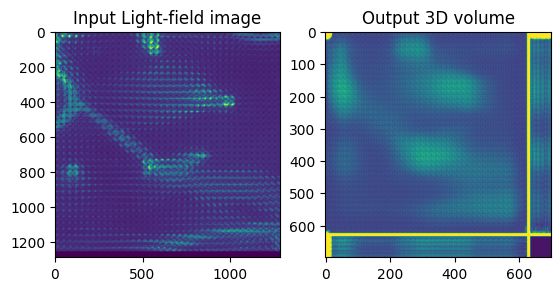

In [13]:
from neural_nets.util.LFUtil import *
import matplotlib.pyplot as plt
# Grab a sample
LF_img_4D, GT_vol = net.val_loader.dataset.__getitem__(0)
LFshape_padded = net.val_loader.dataset.dataset.shape()[1]
# perform reconstruction by calling the network with the image (This calls the forward function in the network)
pred_vol = net(LF_img_4D.unsqueeze(0))

# Compute 2D lenslet image for display
LF_img_lenslet = LF2Spatial(LF_img_4D.unsqueeze(0), LFshape_padded)
# Compute volume Maximum intensity projection
vol_MIP = volume_2_projections(pred_vol)

# Show input and output
plt.subplot(1,2,1)
# Pytorch output dimensions are [batch, channel, x, y]. 
#We grab only the [x,y] and convert it to cpu and numpy for display
plt.imshow(LF_img_lenslet[0,0].cpu().detach().numpy()) 
plt.title('Input Light-field image')
plt.subplot(1,2,2)
plt.imshow(vol_MIP[0,0].cpu().detach().numpy()) 
plt.title('Output 3D volume')
plt.show()

### **Extra**: Continue training a network from a checkpoint
LFNeuralNetworkProto has a function to load networks, which is agnostic to the type of network, as it will extract and import the correct one from the checkpoint information.

##### **Extra.1** Load pretrained network

In [8]:
from neural_nets.LFNeuralNetworkProto import *
# Where is the checkpoint of the network?
checkpoint_path = tb_logger.log_dir.replace("\\","/").replace("//","/") + '/checkpoints/*.ckpt'
# checkpoint_path = 'C:/Users/OldenbourgLab2/Code/napari-LF-neural_nets/examples/pretrained_networks/VCDNet/version_0/checkpoints/*.ckpt'
print("Loading checkpoint from: " + checkpoint_path)
n_retrain_epochs = 10 # How many epochs to train?
# Create network
net = LFNeuralNetworkProto.load_network_from_file(checkpoint_path, LFshape)
# Load datasets
net.configure_dataloader()

##### Extra.2 Create a new trainer and train the network

In [9]:
if n_retrain_epochs > 0:
    # Create a trainer
    trainer = pl.Trainer(logger=tb_logger, accelerator='gpu' if n_gpus>0 else 'cpu', devices=n_gpus, precision=32, max_epochs=n_retrain_epochs)
    # Train the network 
    trainer.fit(model=net, train_dataloaders=net.train_loader, val_dataloaders=net.val_loader)

##### Extra.3 Load a trained network and run inference on a sample

Loading checkpoint from: /space/vizcainj/shared/runs/pretrained_networks/VCDNet/version_3/checkpoints/*.ckpt


Loading images: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


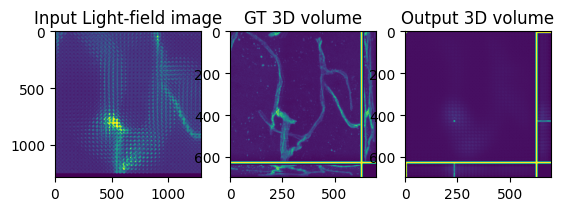

In [10]:
from neural_nets.util.LFUtil import *
import matplotlib.pyplot as plt
from neural_nets.LFNeuralNetworkProto import *

# Where is the checkpoint of the network?
# checkpoint_path = 'C:/Users/OldenbourgLab2/Code/napari-LF-neural_nets/examples/pretrained_networks/VCDNet/version_32/checkpoints/*.ckpt'
print("Loading checkpoint from: " + checkpoint_path)
# Create network
net = LFNeuralNetworkProto.load_network_from_file(checkpoint_path, LFshape)
# Load datasets
net.configure_dataloader()

# Grab a sample
LF_img_4D, GT_vol = net.val_loader.dataset.__getitem__(0)
# perform reconstruction by calling the network with the image (This calls the forward function in the network)
pred_vol = net(LF_img_4D.unsqueeze(0))

# Compute 2D lenslet image for display
LF_img_lenslet = LF2Spatial(LF_img_4D.unsqueeze(0), LFshape_padded)
# Compute volume Maximum intensity projection
vol_pred_MIP = volume_2_projections(pred_vol)
vol_GT_MIP = volume_2_projections(GT_vol.float().unsqueeze(0))

# Show input and output
plt.subplot(1,3,1)
# Pytorch output dimensions are [batch, channel, x, y]. 
#We grab only the [x,y] and convert it to cpu and numpy for display
plt.imshow(LF_img_lenslet[0,0].cpu().detach().numpy()) 
plt.title('Input Light-field image')
plt.subplot(1,3,2)
plt.imshow(vol_GT_MIP[0,0].cpu().detach().numpy()) 
plt.title('GT 3D volume')
plt.subplot(1,3,3)
plt.imshow(vol_pred_MIP[0,0].cpu().detach().numpy()) 
plt.title('Output 3D volume')
plt.show()